In [1]:
# Dependencies
import requests
import json
import pandas as pd
import numpy as np
import gmaps
import matplotlib.pyplot as plt
%matplotlib notebook
from app_token import sf_crime_token
from datetime import date, timedelta
from config import g_key
gmaps.configure(api_key=g_key)

**API Request**<br>
Resource: https://dev.socrata.com/foundry/data.sfgov.org/wg3w-h783

In [2]:
# Base URL
base_url = 'https://data.sfgov.org/resource/wg3w-h783.json'

In [3]:
# Parameters
token = f'$$app_token={sf_crime_token}'
order = '$order=incident_datetime ASC'
limit = '$limit=1000000'

# Dates: One year pre-lockdown and post-lockdown
lockdown_date = date(2020,3,17)
start_date = lockdown_date-timedelta(days=365)
end_date = lockdown_date+timedelta(days=364)
date_range = f"incident_date between '{start_date}' and '{end_date}'"

In [4]:
# Request URL
request_url = f'{base_url}?{token}&{order}&{limit}&$where={date_range}'
print(request_url)

https://data.sfgov.org/resource/wg3w-h783.json?$$app_token=WpAxv73w5WPNB5kiEp4plFP1E&$order=incident_datetime ASC&$limit=1000000&$where=incident_date between '2019-03-18' and '2021-03-16'


**API Response and Data Cleaning**

In [5]:
# DataFrame
data = requests.get(request_url).json()
data_df = pd.DataFrame.from_records(data)

In [6]:
# Clean values
data_df.fillna({'incident_category':'Not Disclosed', 'analysis_neighborhood':'Not Disclosed'}, inplace=True)
data_df['incident_category'].replace(['Offence','\?',' \(A\)'],['Offense','',''], inplace=True, regex=True)
data_df['incident_category'].replace(['Drug Violation','Suspicious','Other Offenses','Other Miscellaneous','Weapons Carrying Etc'], \
                                     ['Drug Offense','Suspicious Occ','Other','Other','Weapons Offense'], inplace=True)
data_df['analysis_neighborhood'].replace('null','Not Disclosed', inplace=True, regex=True)

In [7]:
# Split by pre and post lockdown
pre_df = data_df.loc[data_df['incident_date'] < lockdown_date.strftime('%Y-%m-%d')]
post_df = data_df.loc[data_df['incident_date'] >= lockdown_date.strftime('%Y-%m-%d')]

**Category Analysis**

In [10]:
# Group total incidents by category
pre_cat_ser = pre_df.groupby('incident_category')['incident_id'].nunique().rename('pre_incidents')
post_cat_ser = post_df.groupby('incident_category')['incident_id'].nunique().rename('post_incidents')

In [11]:
# Concatenate pre and post incidents, calculate percent change
cat_df = pd.concat([pre_cat_ser, post_cat_ser], sort=True, axis=1).fillna(0)
cat_df['post_incidents'] = cat_df['post_incidents'].astype(int)
cat_df.drop(labels='Not Disclosed', axis=0, inplace=True)
cat_df['percent_change'] = (cat_df['post_incidents'] - cat_df['pre_incidents']) / cat_df['pre_incidents'] * 100
cat_df.sort_values(by=['post_incidents'], ascending=True, inplace=True)
cat_df.index = cat_df.index + ' (' + cat_df['post_incidents'].astype(str) + ')'

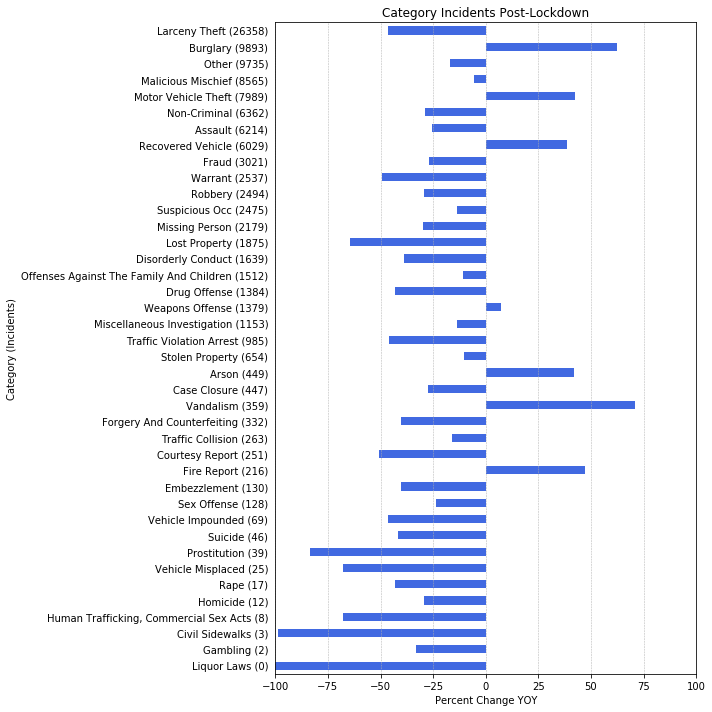

In [12]:
# Plot
plt.figure(figsize=(10,10))
plt.barh(cat_df.index, cat_df['percent_change'], height=0.5, color='royalblue', align='center')
plt.title(f'Category Incidents Post-Lockdown')
plt.xlabel('Percent Change YOY')
plt.ylabel('Category (Incidents)')
plt.xlim(-100, max(100, cat_df['percent_change'].max()))
plt.ylim(-0.5, len(cat_df.index)-0.5)
plt.tick_params(axis='y',left=False)
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.savefig('img/incidents_category.png')

**Narrow Scope to Crimes of Stolen Property Only**

In [ ]:
stolen_types = ['Burglary', 'Larceny Theft', 'Lost Property', 'Motor Vehicle Theft', 'Robbery', 'Stolen Property']
#stolen_types = ['Burglary']
stolen_pre_df = pre_df.loc[data_df['incident_category'].isin(stolen_types)]
stolen_post_df = post_df.loc[data_df['incident_category'].isin(stolen_types)]

**Map Analysis**<br>
Resource: https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html

In [ ]:
# Map incidents by latitude and longitude
def map_incidents(df):
    latlong_df = df[['incident_id', 'latitude', 'longitude']].copy().drop_duplicates().dropna(how='any')
    locations = latlong_df[['latitude', 'longitude']].astype(float)
    fig_layout_dict = {'width':'1000px', 'height':'1000px', 'border':'1px solid black', 'padding':'5px'}
    fig = gmaps.figure(layout=fig_layout_dict)
    heat_layer = gmaps.heatmap_layer(locations, dissipating=True, max_intensity=5, point_radius=5)
    fig.add_layer(heat_layer)
    return fig

In [ ]:
# Map pre-lockdown incidents
map_incidents(stolen_pre_df)

In [ ]:
# Map post-lockdown incidents
map_incidents(stolen_post_df)

**Neighborhood Analysis**

In [ ]:
# Group incidents by neighborhood
def chart_neighborhood_incidents(df, timing):
    district_ser = df.groupby('analysis_neighborhood')['incident_id'].nunique()
    district_ser.sort_values(ascending=True, inplace=True)
    plt.figure(figsize=(10,10))
    plt.barh(district_ser.index, district_ser, height=0.5, color='royalblue', align='center')
    plt.title(f'Neighborhood Incidents {timing}-Lockdown')
    plt.xlabel('Incidents')
    plt.ylabel('Neighborhood')
    plt.ylim(-0.5, len(district_ser)-0.5)
    plt.tick_params(axis='y',left=False)
    plt.tight_layout()
    plt.savefig(f'img/incidents_neighborhood_{timing.lower()}.png')

In [ ]:
# Chart pre-lockdown incidents
chart_neighborhood_incidents(stolen_pre_df, 'Pre')

In [ ]:
# Chart post-lockdown incidents
chart_neighborhood_incidents(stolen_post_df, 'Post')

**Time Analysis**

In [ ]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [ ]:
# Group total incidents by day and hour
def chart_time_incidents(start_date, end_date, df, timing):
    
    # Count occurrence of each day of week within date range
    # Resource: https://numpy.org/doc/stable/reference/generated/numpy.busday_count.html
    days_dict = {}
    def day_counter(start_date, end_date, day):
        day_count = np.busday_count(start_date, end_date+timedelta(days=1), weekmask=day)
        return day_count
    for day in days:
        days_dict[day] = day_counter(start_date, end_date, day)
    
    # Group total incidents by day and hour
    # Resource: https://www.javaer101.com/en/article/17171715.html
    time_df = df[['incident_day_of_week', 'incident_time', 'incident_id']].copy().drop_duplicates()
    day_cats = pd.api.types.CategoricalDtype(categories=days, ordered=True)
    time_df['day_abbr'] = time_df['incident_day_of_week'].str[:3].astype(day_cats)
    time_df['incident_hour'] = time_df['incident_time'].str[:2].astype(int)
    time_ser = time_df.groupby(['day_abbr', 'incident_hour'])['incident_id'].nunique().astype(float)
    
    # Convert total incidents to average incidents by weekday and hour
    def day_count_divisor(day):
        time_ser[day] = time_ser.loc[day].divide(days_dict[day], level='day_abbr')
    for day in days:
        day_count_divisor(day)

    # Plot
    time_ser.unstack(level=0).plot(
        kind='line',
        figsize=(12,8),
        title=f'Average Hourly Incidents {timing}-Lockdown')
    plt.xlabel('Hour')
    plt.ylabel('Average Incidents')
    plt.ylim(0, time_ser.max()*1.2)
    plt.xticks(np.arange(0,24,2))
    plt.legend(title='Day of Week')
    plt.tight_layout()
    plt.savefig(f'img/incidents_hourly_{timing.lower()}.png')

In [ ]:
chart_time_incidents(start_date, lockdown_date-timedelta(days=1), stolen_pre_df, 'Pre')

In [ ]:
chart_time_incidents(lockdown_date, end_date, stolen_post_df, 'Post')